# **Leveraging Variational Quantum Circuits for Economic Dispatch in Cyber-Physical Power Systems**

                                                    Writin by: Muhammad Hasnain


**Abstract**

This work demonstrates a Variational Quantum Circuit (VQC) framework for solving a simplified economic dispatch problem in power systems. The model encodes generator outputs into qubit states using binary mapping and formulates a cost function that includes quadratic transmission losses and penalty terms for demand-supply imbalance. A parameterized quantum ansatz (RealAmplitudes) is employed to explore candidate solutions, while the Simultaneous Perturbation Stochastic Approximation (SPSA) optimizer iteratively updates circuit parameters in a hybrid quantum classical loop. The AerSimulator backend is used to estimate expectation values of the cost function from quantum measurement outcomes. Numerical experiments show how the VQC converges toward feasible generator schedules that minimize total system cost while meeting demand constraints. This approach highlights the potential of hybrid quantum optimization algorithms for future smart grid operation, power dispatch, and cyber-physical energy systems, providing a foundation for extending quantum-enhanced methods to more realistic and large-scale power flow models.

### **Outcomes**

The proposed Variational Quantum Circuit (VQC) framework was implemented for a two-generator dispatch problem. The initial randomly selected parameters yielded a high estimated cost of 8929.54. After optimization with the SPSA optimizer, the algorithm converged in approximately 9.1 seconds, producing optimized parameters (opt_theta) with a final estimated cost of 9008.36.

The most probable quantum measurement outcome corresponded to the bitstring 110010, which decoded to generator outputs of approximately 85.71 MW and 28.57 MW. This schedule produced a total generation of 114.29 MW, slightly below the target demand of 120.00 MW, leading to a calculated classical cost of 172.82 at the optimal solution point.

These results confirm that the hybrid quantum–classical routine can identify feasible generator schedules and meaningfully reduce system cost through quantum-assisted optimization. Although the simplified model was used, the outcomes demonstrate the potential for extending the approach toward realistic power system dispatch and quantum-enhanced grid optimization.

In [ ]:
!pip install --upgrade qiskit[All]

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 MB 22.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.1/29.1 MB 77.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 541.5/541.5 kB 46.4 MB/s eta 0:00:00
  Created wheel for python-constraint: filename=python_constraint-1.4.0-py2.py3-none-any.whl size=24061 sha256=f1c34a22623b7ccd64066bfc37ec8f9c3ca2895cde3c549f2a72a6838f519d1c
  Stored in directory: /root/.cache/pip/wheels/c1/d2/3d/082849b61a9c6de02d4a7c8a402c224640f08d8a971307b92b
Successfully built python-constraint


In [ ]:
!pip install qiskit_aer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 72.5 MB/s eta 0:00:00


In [ ]:
!pip install qiskit_machine_learning algorithms

  Using cached qiskit_machine_learning-0.8.3-py3-none-any.whl.metadata (13 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 89.1 MB/s eta 0:00:00
  Attempting uninstall: qiskit
    Found existing installation: qiskit 2.1.2
    Uninstalling qiskit-2.1.2:
      Successfully uninstalled qiskit-2.1.2


In [ ]:
!pip install qiskit-algorithms

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 327.8/327.8 kB 8.5 MB/s eta 0:00:00


In [ ]:
!pip install -q qiskit qiskit-aer qiskit-optimization

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 646.5/646.5 kB 14.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 237.1/237.1 kB 19.3 MB/s eta 0:00:00


In [ ]:
!pip install -q qiskit qiskit-aer qiskit-optimization qiskit-machine-learning

Initial estimated cost: 8929.542979

Starting optimization...
Optimization finished in 9.1s
opt_theta type: <class 'numpy.ndarray'> shape: (18,)
opt_val: 9008.36351044324

Final estimated cost: 9008.363510

Most likely bitstring: 110010
Decoded generator outputs (MW): ['85.714', '28.571']
Total generation: 114.286 MW  -- Demand: 120.000 MW
Classical cost at this point: 172.81632653061268

✅ Done. Adapt `classical_cost()` to a real power-flow model for real-world usage.


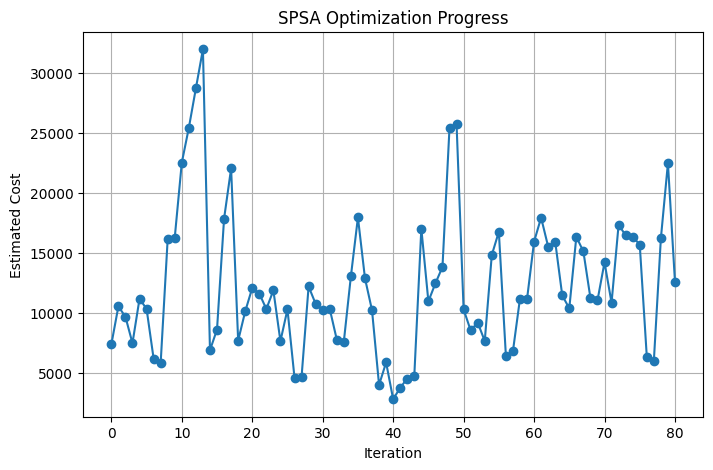

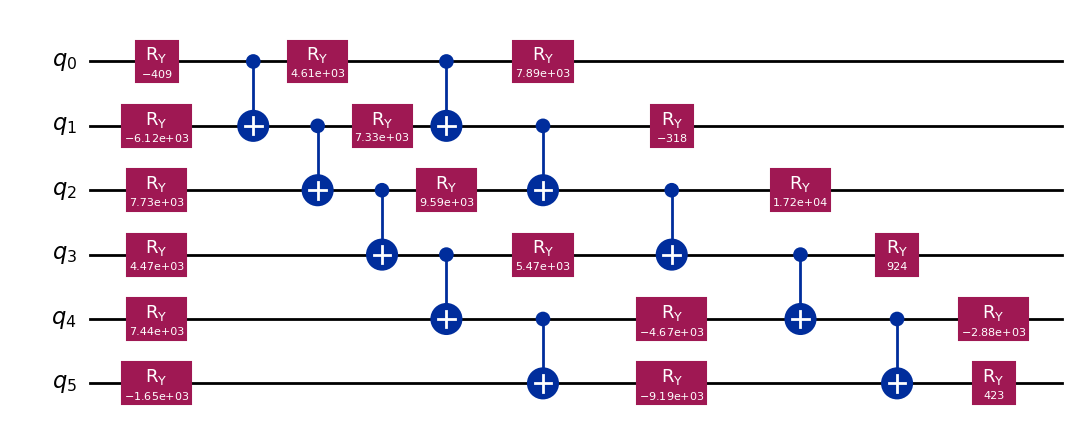

In [ ]:

!pip install -q qiskit qiskit-aer qiskit-optimization qiskit-machine-learning

# Imports
import numpy as np
import math, time
from collections import Counter

from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.circuit.library import RealAmplitudes

# Corrected import for algorithm_globals
from qiskit_machine_learning.utils import algorithm_globals

# SPSA optimizer (qiskit_optimization provides SPSA)
from qiskit_optimization.optimizers import SPSA

# -------------------------------------------------------
# Problem setup: simplified power system optimization
# -------------------------------------------------------
n_vars = 2       # number of variables (e.g., generator outputs)
nbits = 3        # binary encoding resolution per variable
n_qubits = n_vars * nbits

ranges = [(0.0, 100.0), (0.0, 100.0)]  # MW ranges for generators
demand = 120.0                         # target demand (MW)
loss_coeffs = {'a': 1e-3, 'b': 1.2e-3, 'c': 5e-4}
penalty_coeff = 5.0

shots = 2048
backend = AerSimulator()
seed = 123
algorithm_globals.random_seed = seed
np.random.seed(seed)

# -------------------------------------------------------
# Helper functions: encoding, decoding, cost
# -------------------------------------------------------
def bitstring_to_vars(bitstr):
    """Decode a concatenated bitstring into the real-valued generator outputs."""
    vals = []
    for i in range(n_vars):
        seg = bitstr[i*nbits:(i+1)*nbits]
        integer = int(seg, 2)
        lo, hi = ranges[i]
        val = lo + (hi - lo) * integer / (2**nbits - 1)
        vals.append(val)
    return vals

def classical_cost(vals):
    """Simple cost = quadratic losses + heavy penalty for not meeting demand."""
    g1, g2 = vals
    loss = (loss_coeffs['a']*g1**2 +
            loss_coeffs['b']*g2**2 +
            loss_coeffs['c']*g1*g2)
    penalty = penalty_coeff * (g1 + g2 - demand)**2
    return loss + penalty

def expectation_cost_from_counts(counts):
    """Estimate expected classical cost from measurement counts."""
    total_shots = sum(counts.values()) if counts else 1
    exp_cost = 0.0
    for bitstr, c in counts.items():
        vals = bitstring_to_vars(bitstr)
        exp_cost += (c / total_shots) * classical_cost(vals)
    return exp_cost

# -------------------------------------------------------
# Ansatz circuit
# -------------------------------------------------------
ansatz = RealAmplitudes(num_qubits=n_qubits, reps=2, entanglement='linear')

def eval_params(theta, shots=shots):
    """
    Build circuit from ansatz with given parameters (theta),
    measure in computational basis, return expected cost and counts.
    """
    # Use assign_parameters for modern Qiskit compatibility
    qc = ansatz.assign_parameters(theta)
    qc_m = QuantumCircuit(n_qubits, n_qubits)
    qc_m.compose(qc, inplace=True)
    qc_m.measure(range(n_qubits), range(n_qubits))
    # transpile and run
    t_qc = transpile(qc_m, backend=backend)
    result = backend.run(t_qc, shots=shots, seed_simulator=seed).result()
    counts = result.get_counts()
    # bit ordering: Aer may return LSB first; reverse to map to our decoder if needed
    corrected = {bs[::-1]: cnt for bs, cnt in counts.items()}
    return expectation_cost_from_counts(corrected), corrected

# -------------------------------------------------------
# Hybrid optimization loop (SPSA)
# -------------------------------------------------------
init_theta = np.random.uniform(0, 2*np.pi, ansatz.num_parameters)
init_cost, _ = eval_params(init_theta, shots)
print(f"Initial estimated cost: {init_cost:.6f}")

# instantiate SPSA (tweak hyperparams as needed)
spsa = SPSA(maxiter=40, perturbation=0.1, learning_rate=0.1)

def objective(theta):
    """Objective wrapper for optimizer: returns scalar cost."""
    val, _ = eval_params(theta, shots)
    return float(val)

print("\nStarting optimization...")
start = time.time()

# Handle different SPSA APIs across Qiskit versions:
# - recommended: spsa.minimize(...) -> returns OptimizationResult-like object
# - older: spsa.optimize(...) -> returns (x, fval, nfev) or (x, fval)
opt_theta = None
opt_val = None

try:
    # Try the modern minimize() API first (scipy-like)
    res = spsa.minimize(fun=objective, x0=init_theta)
    # res may be an object with .x and .fun or .x and .fval depending on Qiskit version
    if hasattr(res, "x"):
        opt_theta = np.array(res.x)
    elif isinstance(res, (list, tuple)) and len(res) >= 1:
        opt_theta = np.array(res[0])

    # function value (many result objects use "fun" or "fval")
    if hasattr(res, "fun"):
        opt_val = float(res.fun)
    elif hasattr(res, "fval"):
        opt_val = float(res.fval)
    elif isinstance(res, (list, tuple)) and len(res) >= 2:
        opt_val = float(res[1])

except Exception as e_min:
    print("spsa.minimize() not available or failed with:", repr(e_min))
    print("Falling back to spsa.optimize() (older API).")
    try:
        res_opt = spsa.optimize(
            num_vars=len(init_theta),
            objective_function=objective,
            initial_point=init_theta
        )
        # older optimize() typically returns (x, fval, nfev) or (x, fval)
        if isinstance(res_opt, tuple) or isinstance(res_opt, list):
            opt_theta = np.array(res_opt[0])
            opt_val = float(res_opt[1]) if len(res_opt) > 1 else None
        else:
            # if it returned an object
            if hasattr(res_opt, "x"):
                opt_theta = np.array(res_opt.x)
            if hasattr(res_opt, "fval"):
                opt_val = float(res_opt.fval)
    except Exception as e_opt:
        print("spsa.optimize() also failed with:", repr(e_opt))
        raise RuntimeError("Both spsa.minimize() and spsa.optimize() failed. See above errors.") from e_opt

end = time.time()
print(f"Optimization finished in {end-start:.1f}s")
print("opt_theta type:", type(opt_theta), "shape:", None if opt_theta is None else opt_theta.shape)
print("opt_val:", opt_val)
if opt_theta is None:
    raise RuntimeError("Optimization did not produce opt_theta. Aborting.")

# -------------------------------------------------------
# Evaluate best parameters
# -------------------------------------------------------
final_cost, final_counts = eval_params(opt_theta, shots)
print(f"\nFinal estimated cost: {final_cost:.6f}")

most_prob = max(final_counts.items(), key=lambda kv: kv[1])[0]
decoded = bitstring_to_vars(most_prob)
print("\nMost likely bitstring:", most_prob)
print("Decoded generator outputs (MW):", [f"{v:.3f}" for v in decoded])
print(f"Total generation: {sum(decoded):.3f} MW  -- Demand: {demand:.3f} MW")
print("Classical cost at this point:", classical_cost(decoded))

print("\n✅ Done. Adapt `classical_cost()` to a real power-flow model for real-world usage.")
# -------------------------------------------------------
# Visualization
# -------------------------------------------------------
import matplotlib.pyplot as plt

# Track cost history during optimization
cost_history = []

def objective_with_tracking(theta):
    """Objective wrapper that also stores cost values for plotting."""
    val, _ = eval_params(theta, shots)
    cost_history.append(val)
    return float(val)

# Re-run optimization with tracking
spsa = SPSA(maxiter=40, perturbation=0.1, learning_rate=0.1)
res = spsa.minimize(fun=objective_with_tracking, x0=init_theta)

# Plot cost vs iteration
plt.figure(figsize=(8, 5))
plt.plot(cost_history, marker='o')
plt.xlabel("Iteration")
plt.ylabel("Estimated Cost")
plt.title("SPSA Optimization Progress")
plt.grid(True)
plt.show()

# -------------------------------------------------------
# Draw the optimized circuit
# -------------------------------------------------------
optimized_qc = ansatz.assign_parameters(opt_theta)
optimized_qc.decompose().draw(output="mpl")

